In [ ]:
from google.colab import files
uploaded = files.upload()

Saving augmented_train_data.csv to augmented_train_data.csv
Saving test_dataset.csv to test_dataset.csv


In [ ]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import numpy as np
import os

In [ ]:
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import pandas as pd
import time
train_df = pd.read_csv('augmented_train_data.csv')
test_df = pd.read_csv('test_dataset.csv')

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)



Train shape: (1960, 2)
Test shape: (424, 2)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_df['text'], train_df['label'], test_size=0.2, random_state = 36312401)


In [ ]:
def tokenize(texts, labels):
    encodings = tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=128,
        return_tensors="tf"
    )
    dataset = tf.data.Dataset.from_tensor_slices((dict(encodings), labels))
    return dataset

In [ ]:
train_dataset = tokenize(X_train.tolist(), y_train.tolist()).shuffle(1000).batch(32)
val_dataset   = tokenize(X_val.tolist(), y_val.tolist()).batch(32)
test_dataset  = tokenize(test_df['text'].tolist(), test_df['label'].tolist()).batch(32)


In [ ]:
for layer in model.layers:
    layer.trainable = True

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [tf.metrics.SparseCategoricalAccuracy()]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
checkpoint_dir = "./bert_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=2,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, "best_model.h5"),
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]


In [ ]:
start_time = time.time()

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    callbacks=callbacks
)

print("Training time:", round(time.time() - start_time, 2), "seconds")

Epoch 1/5
49/49 [==============================] - ETA: 0s - loss: 0.2922 - sparse_categorical_accuracy: 0.8941
Epoch 1: val_loss improved from inf to 0.02348, saving model to ./bert_checkpoints/best_model.h5
49/49 [==============================] - 96s 1s/step - loss: 0.2922 - sparse_categorical_accuracy: 0.8941 - val_loss: 0.0235 - val_sparse_categorical_accuracy: 0.9974
Epoch 2/5
49/49 [==============================] - ETA: 0s - loss: 0.0243 - sparse_categorical_accuracy: 0.9943
Epoch 2: val_loss improved from 0.02348 to 0.01475, saving model to ./bert_checkpoints/best_model.h5
49/49 [==============================] - 49s 1s/step - loss: 0.0243 - sparse_categorical_accuracy: 0.9943 - val_loss: 0.0147 - val_sparse_categorical_accuracy: 0.9974
Epoch 3/5
49/49 [==============================] - ETA: 0s - loss: 0.0045 - sparse_categorical_accuracy: 1.0000
Epoch 3: val_loss improved from 0.01475 to 0.01345, saving model to ./bert_checkpoints/best_model.h5
49/49 [========================

In [ ]:
loss, acc = model.evaluate(test_dataset)
print(f"\nTest Accuracy: {acc:.4f}")

14/14 [==============================] - 6s 246ms/step - loss: 0.0278 - sparse_categorical_accuracy: 0.9929

Test Accuracy: 0.9929


In [ ]:
pred_logits = model.predict(test_dataset).logits
pred_labels = tf.math.argmax(pred_logits, axis=1).numpy()

14/14 [==============================] - 6s 252ms/step


In [ ]:
print("\nFinal Test Set Evaluation:")
print(classification_report(test_df['label'].tolist(), pred_labels))


Final Test Set Evaluation:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       170
           1       0.99      1.00      0.99       254

    accuracy                           0.99       424
   macro avg       0.99      0.99      0.99       424
weighted avg       0.99      0.99      0.99       424



In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_df['label'].tolist(), pred_labels)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[167   3]
 [  0 254]]


ROC AUC Score: 0.9999
PR AUC Score: 1.0000


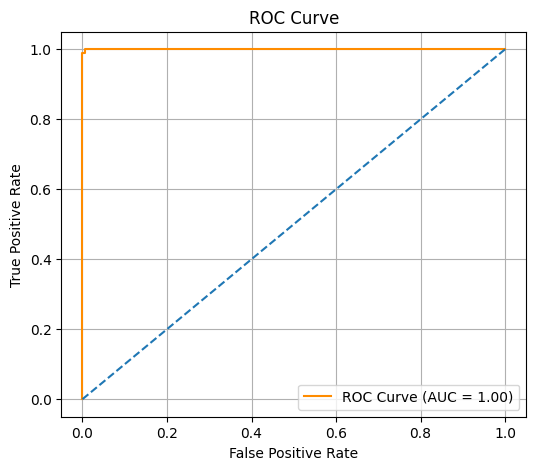

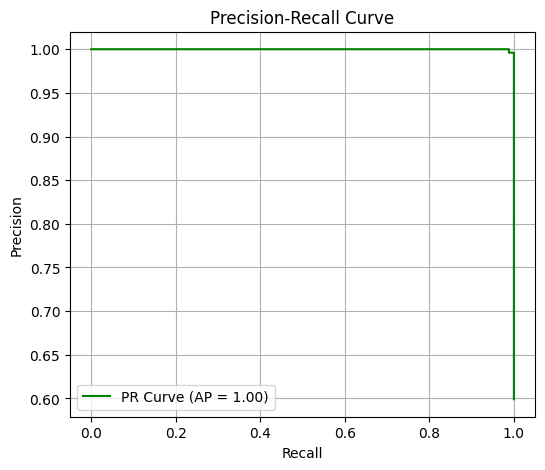

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

y_true = test_df['label'].tolist()
y_scores = tf.nn.softmax(pred_logits, axis=1).numpy()[:, 1]  # Use logits to get probability of class 1

# Scores
roc_auc = roc_auc_score(y_true, y_scores)
pr_auc = average_precision_score(y_true, y_scores)
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"PR AUC Score: {pr_auc:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# PR Curve
precision, recall, _ = precision_recall_curve(y_true, y_scores)
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, color='green', label=f'PR Curve (AP = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()